### Example of plane wave GAN inference with MeshRIR dataset and pretrained model

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model  # noqa
import numpy as np
import matplotlib.pyplot as plt
# use inline plotting
%matplotlib inline
import sys
sys.path.append('./')
import os
import pathlib
# hide warnings from tensorflow and matplotlib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)

from aux_func import (get_measurement_vector, generate_random_pressure_fields, plot_array_pressure,
                      ridge_freq_inference, frequency_inference, mac_similarity, nmse)

2023-03-07 21:56:18.293701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# set seeds for reproduceability
seed = 4321
tf.random.set_seed(seed)
np.random.seed(seed)

### set parameters

In [3]:
# CONSTANTS
# set the path to the results directory using pathlib
results_dir = pathlib.Path('./Results')
model = 'PlanewaveGAN_G_weights'
""" planar data """
datapath = pathlib.Path("..", "data", "Inference files", "MeshRIR_set.npz")
settings = {
    "csgan_iters": 1000,
    "csgan_resets": 1,
    "csgan_lambda": 0.001,
    "conditional_net": False,
    "complex_net": False,
    "adapt_gan_iters": 1000,
    "adapt_gan_lambda": 5e-2,
    "csganlr": 0.001,
    "weights_lr": 0.0001,
    "adapt_lr": 0.002,
    "c": 343.,
    "optimize_weights": False,
    "normalize": True
}
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
results_dir = os.path.join(results_dir, model)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

model_path = pathlib.Path('..','src','Generator Models', model)


fc = [100., 200.,500., 1000., 1400., 2000.]
# fc = [500.]

true_fcs = []
# get uniform frequency vector (for FFT)
fvec = np.fft.rfftfreq(16384, 1 / 16000)
for ffc in fc:
    find = np.argmin(fvec < ffc)
    true_fcs.append(fvec[find])

In [4]:
# get data
datadict = get_measurement_vector(datapath)

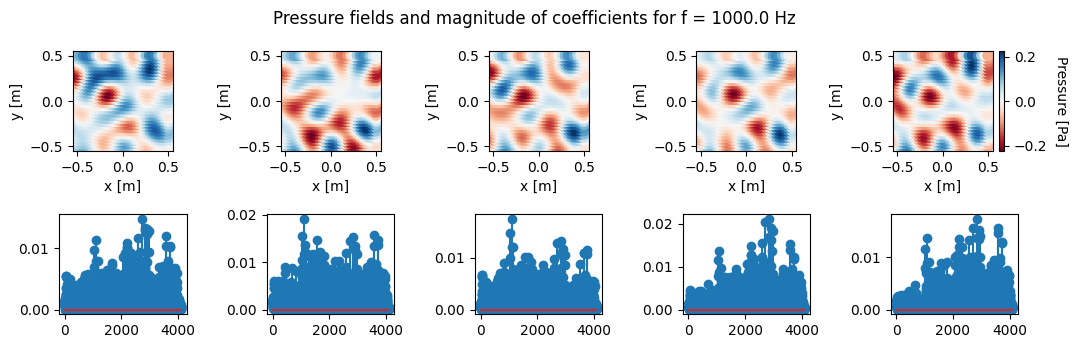

In [5]:
# %% plot random pressure fields
nfields = 5
pp, _ = generate_random_pressure_fields(fc[3], nfields, model_direc=model_path, plot=True)

Reconstructing...:   0%|          | 0/6 [00:00<?, ?it/s]


Number of mics used as data:  67


Frequency: 2000.0 Hz MAC: 6.6983e-01 NMSE: -2.5770e+00: 100%|██████████| 6/6 [00:18<00:00,  3.06s/it]    


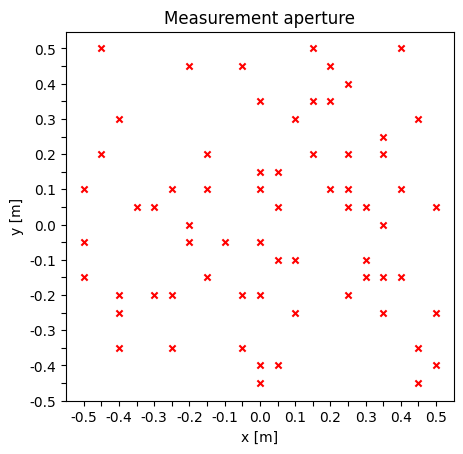

In [6]:
# %% Ridge regression
p_inference_ridge, ptrue_ridge, Nmics, mask = ridge_freq_inference(true_fcs, datadict, settings,
                                                                   subsample_ratio=0.15, src_indx=7, plot_mic= True)

In [7]:
# planewave GAN
pinference_csgm, ptrue_ptych, ptrue, Nmics, mask = frequency_inference(true_fcs,
                                                                       datadict,
                                                                       settings,
                                                                       model_direc=model_path,
                                                                       subsample_ratio=0.15,
                                                                       src_indx=7)


Reconstructing...:   0%|          | 0/6 [00:00<?, ?it/s]

iter: 999 loss: 1.973E-02, misfit: 1.374E-02, || z ||_2 : 5.994E+00 : 100%|██████████| 1000/1000 [00:37<00:00, 26.81it/s]
iter: 999 Loss: 1.1802e+00 Misfit: 1.3271e-01 || x - x_hat||_2 ^2: 1.0497e+01, MAC loss : 5.2265e-01: 100%|██████████| 1000/1000 [00:44<00:00, 22.63it/s]
Frequency: 100.5859375 Hz MAC: 3.2295e-01 NMSE: 6.6748e+00:  17%|█▋        | 1/6 [01:22<06:52, 82.44s/it]

iter: 999 loss: 1.513E-02, misfit: 8.502E-03, || z ||_2 : 6.629E+00 : 100%|██████████| 1000/1000 [00:36<00:00, 27.06it/s]
iter: 999 Loss: 4.7056e-01 Misfit: 1.2032e-01 || x - x_hat||_2 ^2: 6.4247e+00, MAC loss : 2.9005e-02: 100%|██████████| 1000/1000 [00:43<00:00, 23.03it/s]
Frequency: 200.1953125 Hz MAC: 9.1134e-01 NMSE: -7.4669e+00:  33%|███▎      | 2/6 [02:43<05:25, 81.50s/it]

iter: 999 loss: 2.407E-02, misfit: 1.497E-02, || z ||_2 : 9.102E+00 : 100%|██████████| 1000/1000 [00:36<00:00, 27.13it/s]
iter: 999 Loss: 4.8067e-01 Misfit: 1.6205e-01 || x - x_hat||_2 ^2: 5.1771e+00, MAC loss : 5.9765e-02: 100%|██████████| 1000/1000 [00:43<00:00, 22.88it/s]
Frequency: 500.0 Hz MAC: 9.6650e-01 NMSE: -5.5547e+00:  50%|█████     | 3/6 [04:04<04:03, 81.28s/it]      

iter: 999 loss: 2.361E-02, misfit: 1.558E-02, || z ||_2 : 8.030E+00 : 100%|██████████| 1000/1000 [00:37<00:00, 26.90it/s]
iter: 999 Loss: 3.8570e-01 Misfit: 1.2057e-01 || x - x_hat||_2 ^2: 2.9805e+00, MAC loss : 1.1611e-01: 100%|██████████| 1000/1000 [00:43<00:00, 22.90it/s]
Frequency: 1000.0 Hz MAC: 7.9965e-01 NMSE: -3.8558e+00:  67%|██████▋   | 4/6 [05:25<02:42, 81.29s/it]

iter: 999 loss: 2.341E-02, misfit: 1.556E-02, || z ||_2 : 7.854E+00 : 100%|██████████| 1000/1000 [00:37<00:00, 26.36it/s]
iter: 999 Loss: 3.3440e-01 Misfit: 1.1969e-01 || x - x_hat||_2 ^2: 2.7627e+00, MAC loss : 7.6582e-02: 100%|██████████| 1000/1000 [00:44<00:00, 22.55it/s]
Frequency: 1400.390625 Hz MAC: 5.7802e-01 NMSE: -1.6767e+00:  83%|████████▎ | 5/6 [06:48<01:21, 81.91s/it]

iter: 999 loss: 2.600E-02, misfit: 1.581E-02, || z ||_2 : 1.018E+01 : 100%|██████████| 1000/1000 [00:36<00:00, 27.14it/s]
iter: 999 Loss: 2.8840e-01 Misfit: 1.1616e-01 || x - x_hat||_2 ^2: 3.3849e+00, MAC loss : 2.9980e-03: 100%|██████████| 1000/1000 [00:42<00:00, 23.55it/s]
Frequency: 2000.0 Hz MAC: 2.6835e-01 NMSE: 1.0852e+00: 100%|██████████| 6/6 [08:08<00:00, 81.40s/it]      


Frequency:  2000.0 Hz
--CSGM-- 
MAC: 0.148, NMSE: 0.532
--PWGAN-- 
MAC: 0.268, NMSE: 1.085
--Ridge-- 
MAC: 0.67, NMSE: -2.577


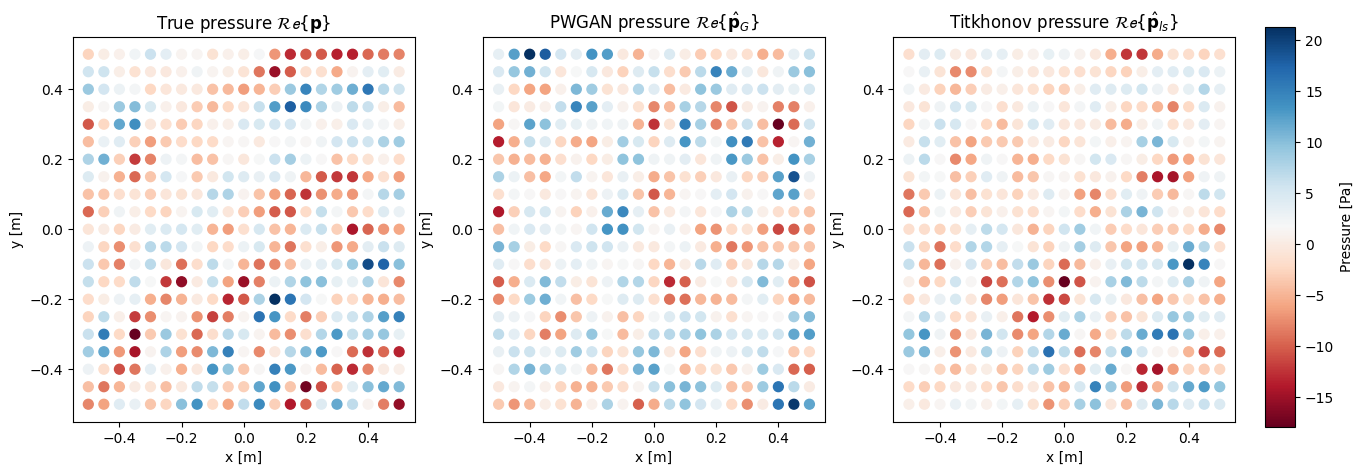

In [15]:
# %% print errors
plt_indx = 5
# reshape vectors
ptrue_plt = ptrue[plt_indx]
ptrue_ptych_plt = ptrue_ptych[plt_indx]
pinference_csgm_plt = pinference_csgm[plt_indx]
p_inference_ridge_plt = p_inference_ridge[plt_indx]
ptrue_ridge_plt = ptrue_ridge[plt_indx]
print("Frequency: ", fc[plt_indx], "Hz")
print(f"--CSGM-- \nMAC: {mac_similarity(ptrue_plt, pinference_csgm_plt).round(3)}, NMSE: {nmse(ptrue_plt, pinference_csgm_plt).round(3)}")
print(f"--PWGAN-- \nMAC: {mac_similarity(ptrue_plt, ptrue_ptych_plt).round(3)}, NMSE: {nmse(ptrue_plt, ptrue_ptych_plt).round(3)}")
print(f"--Ridge-- \nMAC: {mac_similarity(ptrue_ridge_plt, p_inference_ridge_plt).round(3)}, NMSE: {nmse(ptrue_ridge_plt, p_inference_ridge_plt).round(3)}")

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0], sc = plot_array_pressure(ptrue[plt_indx], array_grid=datadict['grid_mic'], ax=ax[0])
ax[0].set_title(r'True pressure $\mathcal{Re}\{ \mathbf{p}\}$')
ax[1], _ = plot_array_pressure(ptrue_ptych[plt_indx], array_grid=datadict['grid_mic'], ax=ax[1])
ax[1].set_title(r'PWGAN pressure $\mathcal{Re}\{ \hat{\mathbf{p}}_G\}$')
ax[2], _ = plot_array_pressure(p_inference_ridge[plt_indx], array_grid=datadict['grid_mic'], ax=ax[2])
ax[2].set_title(r'Titkhonov pressure $\mathcal{Re}\{ \hat{\mathbf{p}}_{ls}\}$')
# create new axis for colorbar
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
fig.colorbar(sc, cax=cax)
cax.set_ylabel(r'Pressure [Pa]')
fig.show()


In [16]:
# get all nmse and mac and plot
nmse_ridge = []
mac_ridge = []
nmse_csgm = []
mac_csgm = []
nmse_pwgan = []
mac_pwgan = []
for i in range(len(ptrue)):
    nmse_ridge.append(nmse(ptrue_ridge[i], p_inference_ridge[i]))
    mac_ridge.append(mac_similarity(ptrue_ridge[i], p_inference_ridge[i]))
    nmse_csgm.append(nmse(ptrue[i], pinference_csgm[i]))
    mac_csgm.append(mac_similarity(ptrue[i], pinference_csgm[i]))
    nmse_pwgan.append(nmse(ptrue[i], ptrue_ptych[i]))
    mac_pwgan.append(mac_similarity(ptrue[i], ptrue_ptych[i]))


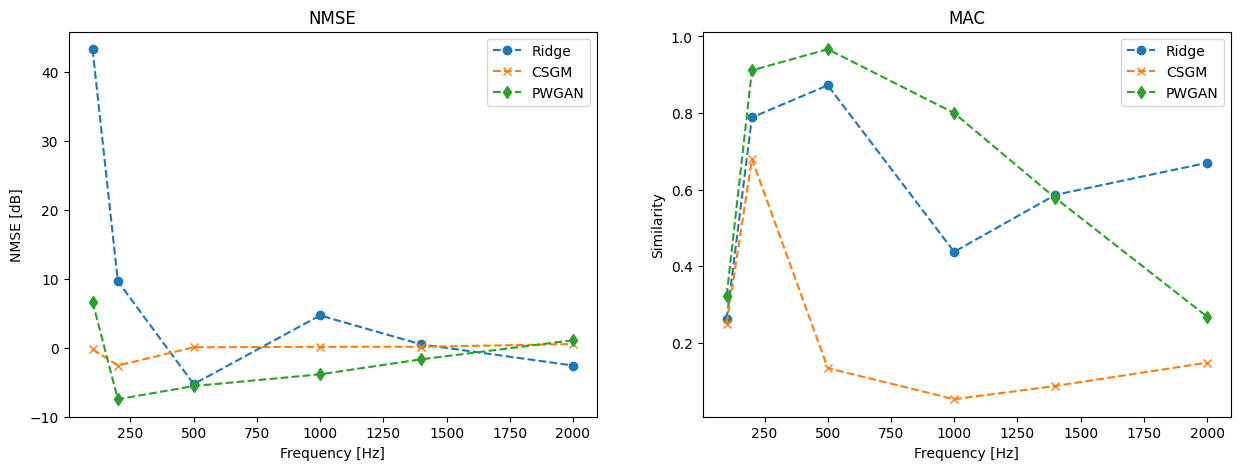

In [17]:
# %%
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(fc,nmse_ridge, label='Ridge', linestyle = '--', marker = 'o')
ax[0].plot(fc,nmse_csgm, label='CSGM', linestyle = '--', marker = 'x')
ax[0].plot(fc,nmse_pwgan, label='PWGAN', linestyle = '--', marker = 'd')
ax[0].set_title('NMSE')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('NMSE [dB]')
ax[0].legend()
ax[1].plot(fc,mac_ridge, label='Ridge', linestyle = '--', marker = 'o')
ax[1].plot(fc,mac_csgm, label='CSGM', linestyle = '--', marker = 'x')
ax[1].plot(fc,mac_pwgan, label='PWGAN', linestyle = '--', marker = 'd')
ax[1].set_title('MAC')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Similarity')

ax[1].legend()
fig.show()
